# Accessing and Processing Cabled Profiler Optical Absorption and Attenuation (OPTAA) Data from OOI

OOI uses the [Sea-Bird Electronics, AC-S In-Situ Spectrophotometer](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) to measure the in situ absorption and beam attenuation coefficients from approximately 400 to 750 nm at a 4 nm resolution. Each sensor is equipped with a unique filter set that determines the exact wavelengths measured and the total number of wavelengths measured. This difference in the number of measured wavelengths and, to a certain extent, their specific values can cause complications when trying to compare measurements across deployments. One solution, presented here, is to reset the number of wavelengths for each unique instrument/deployment instance using fill values to pad out the number of wavelengths and the absorption and beam attenuation measurements to a fixed number of wavelengths. This creates a common dimension for the number of wavelengths that can be used when subsequently concatenating data across deployments.

This example develops off of the [process_kdata_optaa notebook](process_kdata_optaa.ipynb) to demonstrate the steps a user would use to access and process the [Sea-Bird Scientific AC-S](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) from one of the [cabled shallow profilers](https://oceanobservatories.org/marine-technologies/profilers/) deployed as part of the [Cabled Continental Margin Array portion of the OOI Regional Cabled Array](https://oceanobservatories.org/array/cabled-continental-margin-array/) ([RS01SBSP](https://oceanobservatories.org/site/rs01sbps/)). 

The benefit to using the local data directory (as noted in the [process_kdata_optaa notebook](process_kdata_optaa.ipynb)), as opposed to the Gold Copy THREDDS catalog or the OOI M2M system, is the speed of access to the data. In the M2M system, each and every user request for the data requires the system to collect, process and format the data prior to delivery. For complex data, or data that requires extensive processing, this time can be quite lengthy. With the Gold Copy THREDDS catalog, those requests have already been done for you and you can just start with downloading the data, but there is still a time cost to downloading files over the internet. With local directory access, the data files can be directly loaded from disk with no need to download them from a remote server. This becomes more important when working with the higher volume cabled array data.

Note, this example will only work on the OOI JupyterHub where we have access to the kdata directory. If you want to run this code from your home or work computer, simply replace the `load_kdata` function calls with `load_gc_thredds`.

In [1]:
# load needed processing utilities
import os

from ooi_data_explorations.common import get_vocabulary, load_kdata, update_dataset, ENCODINGS
from ooi_data_explorations.cabled.process_optaa import optaa_profiler

from matplotlib import pyplot as plt

In [2]:
# Setup needed parameters for the request, the user would need to vary these to suit their own needs and
# sites/instruments of interest. Site, node, sensor, stream and delivery method names can be obtained from the
# Ocean Observatories Initiative web site. The last two will set path and naming conventions to save the data
# to the local disk
site = 'RS01SBPS'                               # OOI Net site designator
node = 'SF01A'                                  # OOI Net node designator
sensor = '3B-OPTAAD101'                         # OOI Net sensor designator
method = 'streamed'                             # OOI Net data delivery method
stream = 'optaa_sample'                         # OOI Net stream name
level = 'profiler'                              # local directory name, level below site
instrmt = 'optaa'                               # local directory name, instrument below level
deploy = 4                                      # Use data from Deployment 4
tag = 'deployment{:04d}*OPTAA*201708*.nc'.format(deploy)  # create a file globbing tag to select the data to download only from the month of August
vocab = get_vocabulary(site, node, sensor)[0]

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'acs_workshop/data/reprocess', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

In [3]:
%%time
# load data from the local kdata directory
optaa = load_kdata(site, node, sensor, method, stream, tag)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


Merging the data files into a single dataset
CPU times: user 3.16 s, sys: 937 ms, total: 4.09 s
Wall time: 5.62 s


In [4]:
# view the dataset as downloaded from OOI (with some minor modifications, e.g. switching dimensions from obs to time)
optaa

<xarray.Dataset> Size: 654MB
Dimensions:                       (time: 309434, wavelength: 84, string3: 3)
Coordinates:
  * wavelength                    (wavelength) int32 336B 0 1 2 3 ... 81 82 83
  * time                          (time) datetime64[ns] 2MB 2017-08-04T20:00:...
Dimensions without coordinates: string3
Data variables: (12/30)
    external_temp_raw             (time) uint16 619kB 40623 40619 ... 38099
    c_signal_counts               (time, wavelength) uint16 52MB 717 ... 6246
    deployment                    (time) int32 1MB 4 4 4 4 4 4 4 ... 4 4 4 4 4 4
    a_signal_counts               (time, wavelength) uint16 52MB 988 ... 9229
    lat                           (time) float64 2MB 44.53 44.53 ... 44.53 44.53
    int_ctd_pressure              (time) float64 2MB 169.2 169.2 ... 24.45 24.46
    ...                            ...
    a_signal_dark_counts          (time) uint16 619kB 704 704 703 ... 704 704
    c_reference_counts            (time, wavelength) uint16 52MB 1297 ... 8456
    a_reference_dark_counts       (time) uint16 619kB 462 461 461 ... 464 464
    checksum                      (time) uint16 619kB 65535 65535 ... 65535
    depth                         (time) float64 2MB 167.8 167.8 ... 24.25 24.26
    sea_water_temperature         (time) float64 2MB 7.856 7.856 ... 12.2 12.19
Attributes: (12/67)
    node:                               SF01A
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             optaa_sample
    ...                                 ...
    geospatial_lon_max:                 -125.389664
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

You can just start working with the OOI OPTAA data as-is at this point. However, the OOI OPTAA data sets do not include data products from the intermediate optical absorption and beam attenuation processing steps, where:

- the data has been converted from the raw, but has not been corrected for the effects of temperature and salinity or scattering
- the data has been corrected for the effects of temperature and salinity, but the scattering correction has not been applied to the optical absorption data
- the optical absorption data has been corrected for effects of scattering (this example utilizes the baseline scatter correction method)

Instead the OOI OPTAA only has the raw data and the final, temperature, salinity and scatter corrected data. It is considered good practice to make the intermediate data products available to users, especially more advanced users wishing to assess different methods for the scatter corrections. Additionally, if corrections to the spectra are required, using offsets determined by pre-deployment calibrations, these intermediate data products will be needed.

The `process_optaa` module (with different processing functions based on the platform the AC-S was deployed on) has been set up to recalculate these intermediate products starting from the raw measurements. Additionally, the scattering correction has been switched to the simpler [Baseline Correction](https://ioccg.org/wp-content/uploads/2020/09/absorption_protocol_final-incl-cover_rev.pdf) method from the [modified proportional method](https://github.com/cwingard/ion-functions/blob/master/ion_functions/data/opt_functions.py#L508) employed by OOI. This simpler algorithm tends to be more robust across all deployments, but arguments can be made for trying different methods. With the reprocessed data, the option to try different scatter correction methods is now a much simpler process.

Additionally, profiling datasets created by OOI do not include a way to distinguish between profiles. We can use the profiler pressure record to construct a `profile` variable that we can later use to sub-select unique profiles for examination.

In order to create these intermediate data products, we first need to download the vendor calibration data for the instrument from the OOI Asset Management records accessible via the OOI M2M system. The `cal_file` variable created above will hold this data. The first time the calibration data is downloaded, this file will be created. After that, the code will reuse the already downloaded data. The calibration data is saved in a `JSON` formatted data file, making it both human and machine readable.

In [5]:
%%time
# clean-up and reorganize the profiler data (create a profile ID and bin the data into 25 cm bins for each profile)
optaa = optaa_profiler(optaa, cal_file)

Determining profiler movement ...
Profiler moved during the deployment, treating data as a series of profiles.
Sub-selecting upcast data only from the data set ...
Creating and adding a profile variable to the data set ...
Smoothing and binning each profile into 25 cm depth bins ...: 100%|██████████| 12/12 [00:21<00:00,  1.78s/it]
Re-processing the raw data, creating intermediate data products ...


Converting attenuation data ...: 100%|██████████| 7860/7860 [00:01<00:00, 6693.94it/s]


CPU times: user 6 s, sys: 1.54 s, total: 7.54 s
Wall time: 27.9 s


In [6]:
# show the results of the re-processed data in comparison to the original
optaa

<xarray.Dataset> Size: 83MB
Dimensions:                       (time: 7860, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 63kB 2017-08-04T20:24...
  * wavelength_number             (wavelength_number) int64 800B 0 1 2 ... 98 99
Data variables: (12/38)
    external_temp_raw             (time) int64 63kB 41077 41078 ... 38112 38106
    deployment                    (time) int64 63kB 4 4 4 4 4 4 ... 4 4 4 4 4 4
    lat                           (time) float64 63kB 44.53 44.53 ... 44.53
    sea_water_pressure            (time) float64 63kB 196.6 196.4 ... 24.2 23.97
    elapsed_run_time              (time) float64 63kB 1.49e+06 ... 3.758e+06
    lon                           (time) float64 63kB -125.4 -125.4 ... -125.4
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 6MB 400.0...
    c_signal                      (time, wavelength_number) int64 6MB 695 ......
    c_reference                   (time, wavelength_number) int64 6MB 1275 .....
    beam_attenuation              (time, wavelength_number) float64 6MB 0.260...
    cpg                           (time, wavelength_number) float64 6MB 0.257...
    cpg_ts                        (time, wavelength_number) float64 6MB 0.259...
Attributes: (12/67)
    node:                               SF01A
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             optaa_sample
    ...                                 ...
    geospatial_lon_max:                 -125.389664
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites. Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, by computing different parameters (chlorophyll concentration, POC, and absorption ratios) from the absorption and attenuation records and by reviewing the shape and magnitude of the aborption and attenuation spectra.

In [7]:
nc_file = ('{}.{}.{}.deploy{:02d}.reprocessed.nc'.format(site.lower(), level, instrmt, deploy))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

In [8]:
# split the data into profiles using the profile variable added in the above processing
profiles = optaa.groupby('profile')
profiles[12]

<xarray.Dataset> Size: 7MB
Dimensions:                       (time: 671, wavelength_number: 100)
Coordinates:
  * time                          (time) datetime64[ns] 5kB 2017-10-08T20:43:...
  * wavelength_number             (wavelength_number) int64 800B 0 1 2 ... 98 99
Data variables: (12/38)
    external_temp_raw             (time) int64 5kB 40873 40872 ... 38112 38106
    deployment                    (time) int64 5kB 4 4 4 4 4 4 4 ... 4 4 4 4 4 4
    lat                           (time) float64 5kB 44.53 44.53 ... 44.53 44.53
    sea_water_pressure            (time) float64 5kB 192.9 192.6 ... 24.2 23.97
    elapsed_run_time              (time) float64 5kB 5.988e+04 ... 3.758e+06
    lon                           (time) float64 5kB -125.4 -125.4 ... -125.4
    ...                            ...
    wavelength_c                  (time, wavelength_number) float64 537kB 400...
    c_signal                      (time, wavelength_number) int64 537kB 675 ....
    c_reference                   (time, wavelength_number) int64 537kB 1262 ...
    beam_attenuation              (time, wavelength_number) float64 537kB 0.3...
    cpg                           (time, wavelength_number) float64 537kB 0.3...
    cpg_ts                        (time, wavelength_number) float64 537kB 0.3...
Attributes: (12/67)
    node:                               SF01A
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             optaa_sample
    ...                                 ...
    geospatial_lon_max:                 -125.389664
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used, but it should be producing values very close to the CTD (the AC-S temperaure sensor is not as accurate as the CTD). All three measurements should be very similar, with a couple of caveats. This data is from a profiling system. The AC-S temperature sensors do not have the same response rate as the CTD temperature sensor, so there will be some degree of hysteris in those temperature signals as the profiler rises through the thermocline as function of the ascent rate. The internal instrument temperaure will show this affect the most.

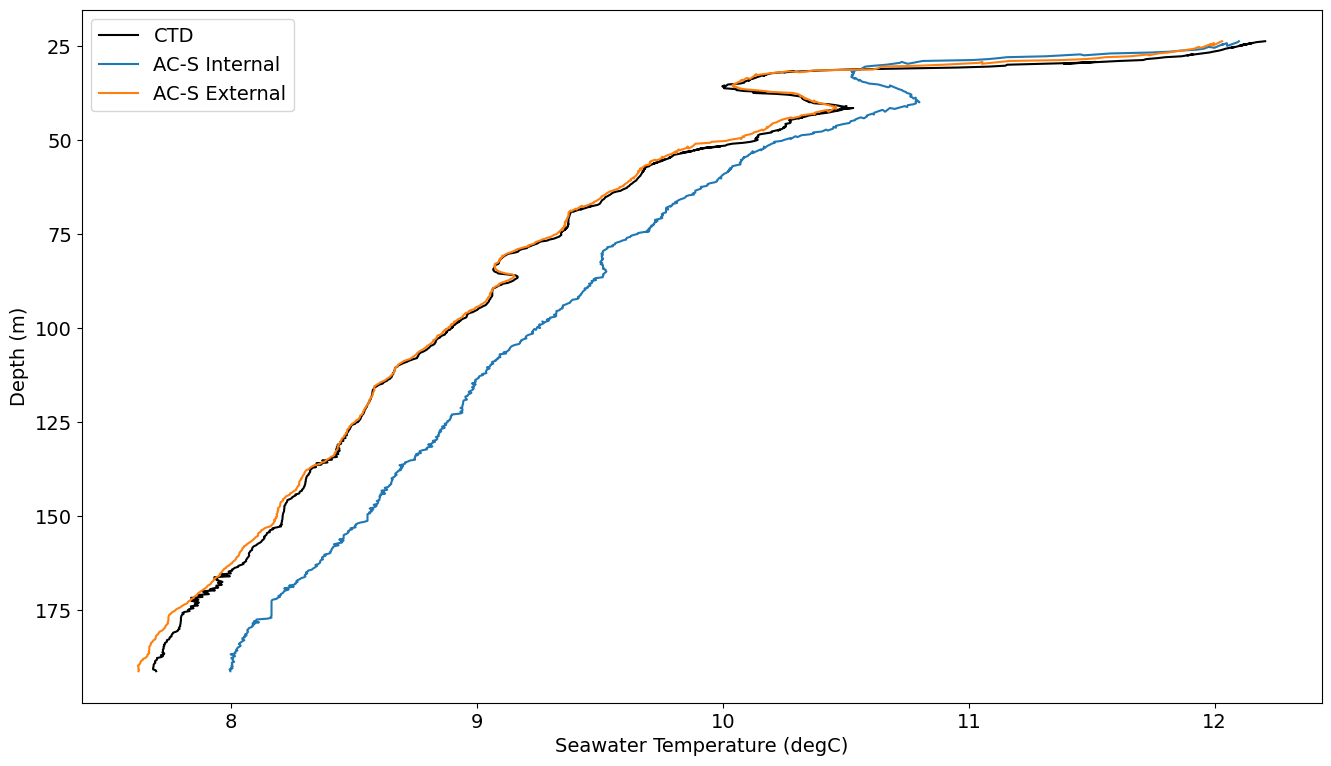

In [9]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 10
profile = profiles[12]
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['sea_water_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

There is really good agreement between the AC-S external temperature sensor and the CTD! This is not always the case. We normally expect some offset between the two and some smoothing of the AC-S temperature record due to a slower response rate. While there are differences, they are slight. Most likely this is due to the slower ascent rate of the cabled shallow profiler (~5 cm/s), giving the external temperature sensor time to respond.

In addition to reviewing the temperature data, the AC-S can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentrations. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors. Additionally, pigment ratios can be calculated to assess the impacts of biofouling, potential changes in community composition, light history or bloom health and age:

* CDOM Ratio -- ratio of CDOM absorption in the violet portion of the spectrum at 412 nm relative to chlorophyll absorption at 440 nm. Ratios greater than 1 indicate a preponderance of CDOM absorption relative to chlorophyll.
* Carotenoid Ratio -- ratio of carotenoid absorption in the blue-green portion of the spectrum at 490 nm relative to chlorophyll absorption at 440 nm. A changing carotenoid to chlorophyll ratio may indicate a shift in phytoplankton community composition in addition to changes in light history or bloom health and age.
* Phycobilin Ratio -- ratio of phycobilin absorption in the green portion of the spectrum at 530 nm relative to chlorophyll absorption at 440 nm. Different phytoplankton, notably cyanobacteria, utilize phycobilins as accessory light harvesting pigments. An increasing phycobilin to chlorophyll ratio may indicate a shift in phytoplankton community composition.
* Q Band Ratio -- the Soret and the Q bands represent the two main absorption bands of chlorophyll. The former covers absorption in the blue region of the spectrum, while the latter covers absorption in the red region. A decrease in the ratio of the intensity of the Soret band at 440 nm to that of the Q band at 676 nm may indicate a change in phytoplankton community structure. All phytoplankton contain chlorophyll a as the primary light harvesting pigment, but green algae and dinoflagellates contain chlorophyll b and c, respectively, which are spectrally redshifted compared to chlorophyll a.

Before we look at the estimated chlorophyll and POC data, it will be helpful to pull in data from the co-located Sea-Bird Electronics ECO Triplet (FLORT). This data can also be used to create estimates of chlorophyll and POC, which can then be cross-compared to the AC-S estimates. This provides a useful means of cross-validating the data.

In [10]:
from ooi_data_explorations.cabled.process_flort import flort_profiler

# Setup needed parameters for the request
sensor = '3A-FLORTD101'     # OOI Net sensor designator
stream = 'flort_d_data_record'  # OOI Net stream name
method = 'streamed'         # OOI Net data delivery method
instrmt = 'flort'           # local directory name, instrument below level
tag = 'deployment{:04d}*FLORT*201708*.nc'.format(deploy)  # create a regex tag to select the data to download

# We are after the the data from deployment 3
vocab = get_vocabulary(site, node, sensor)[0]

# load data from the local kdata directory
flort = load_kdata(site, node, sensor, method, stream, tag)
flort = flort_profiler(flort)

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 841 * (flort['bback'] - flort['sea_water_scattering_coefficient'])**0.395  # derived from Cetinic et al., 2012 (using Balch et al., 2010 equation))

Loading and Processing Data Files: 100%|██████████| 1/1 [00:16<00:00, 16.79s/it]


Merging the data files into a single dataset


In [11]:
# show the FLORT dataset
flort

<xarray.Dataset> Size: 369MB
Dimensions:                                     (time: 2207415)
Coordinates:
  * time                                        (time) datetime64[ns] 18MB 20...
Data variables: (12/35)
    estimated_chlorophyll_qc_results            (time) uint8 2MB 29 29 ... 29 29
    fluorometric_cdom                           (time) float64 18MB 2.276 ......
    fluorometric_cdom_qc_executed               (time) uint8 2MB 29 29 ... 29 29
    fluorometric_cdom_qartod_results            (time) uint8 2MB 1 1 1 ... 1 1 1
    fluorometric_chlorophyll_a_qartod_results   (time) uint8 2MB 1 1 1 ... 1 1 1
    fluorometric_cdom_qartod_executed           (time) <U2 18MB '11' ... '11'
    ...                                          ...
    sea_water_temperature                       (time) float64 18MB 7.856 ......
    estimated_chlorophyll_qc_summary_flag       (time) int32 9MB 1 1 1 ... 1 1 1
    bback_qc_summary_flag                       (time) int32 9MB 3 3 3 ... 3 3 3
    beta_700_qc_summary_flag                    (time) int32 9MB 3 3 3 ... 3 3 3
    fluorometric_cdom_qc_summary_flag           (time) int32 9MB 1 1 1 ... 1 1 1
    estimated_poc                               (time) float64 18MB 37.12 ......
Attributes: (12/67)
    node:                               SF01A
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -125.389664
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [12]:
# add the estimated chlorophyll and POC from the FLORT data to the AC-S data
import numpy as np
chl = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_chlorophyll)
poc = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_poc)

optaa['fluorometric_chlorophyll'] = ('time', chl)
optaa['backscatter_poc'] = ('time', poc)
profiles = optaa.groupby('profile')
profile = profiles[12]

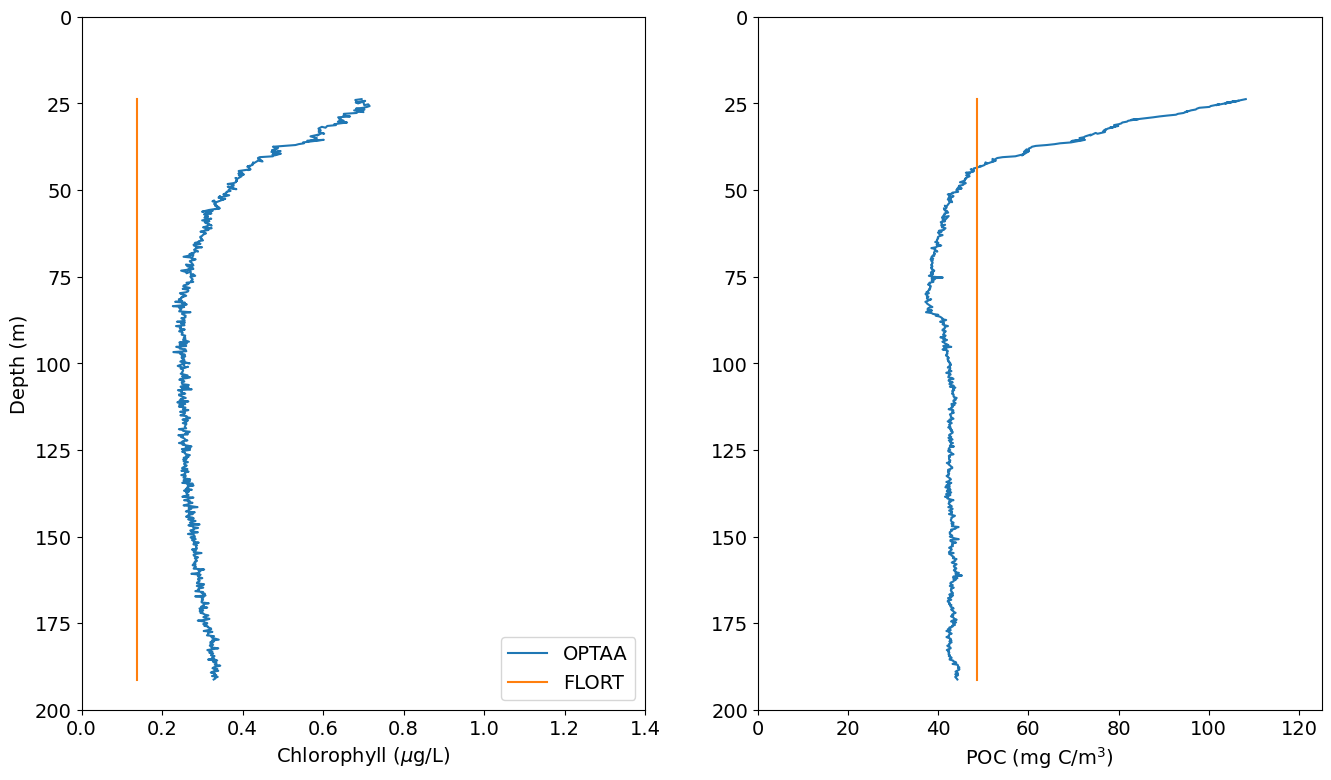

In [13]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'], label='OPTAA')
plt.plot(profile['fluorometric_chlorophyll'], profile['depth'], label='FLORT')
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 1.4])
plt.ylim([0, 200])
plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.plot(profile['backscatter_poc'], profile['depth'])
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 125])
plt.ylim([0, 200])
plt.gca().invert_yaxis()
plt.show()

At first glance, the agreement between the estimated concentrations, especially chlorophyll, doesn't look as good as we would like. However, looking again, the magnitude of the differences is quite small, most likely well within the margin of error for these different methods of estimating these parameters.

Let's take a look at the shape of the spectra to see what they will tell us....

/home/jovyan/venvs/jupyter-book/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/venvs/jupyter-book/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/venvs/jupyter-book/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/venvs/jupyter-book/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Recalculated Attenuation Data')

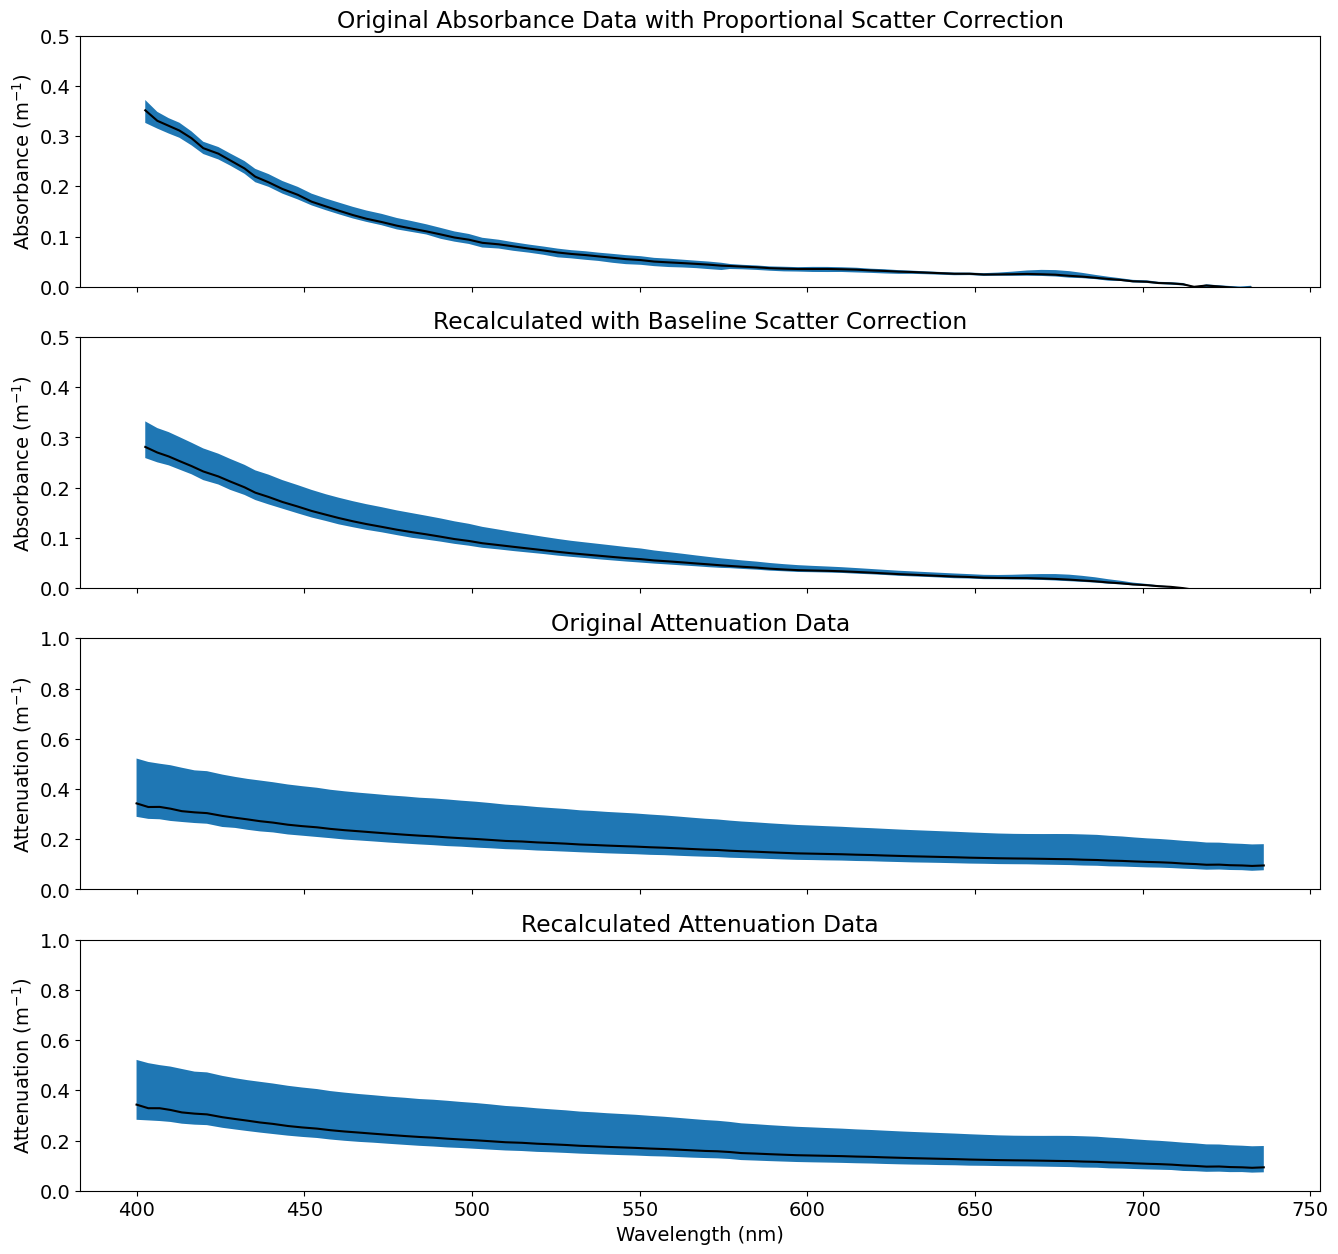

In [14]:
# plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,15))

ax1 = plt.subplot(411)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].mean(axis=0) + profile['optical_absorption'].std(axis=0) * 3)
plt.ylim([0, 0.5])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Original Absorbance Data with Proportional Scatter Correction')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apg_ts_s'].min(axis=0), 
                 profile['apg_ts_s'].mean(axis=0) + profile['apg_ts_s'].std(axis=0) * 3)
plt.ylim([0, 0.5])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Recalculated with Baseline Scatter Correction')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].mean(axis=0) + profile['beam_attenuation'].std(axis=0) * 3)
plt.ylim([0, 1])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.title('Original Attenuation Data')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['cpg_ts'].min(axis=0), 
                 profile['cpg_ts'].mean(axis=0) + profile['cpg_ts'].std(axis=0) * 3)
plt.ylim([0, 1])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.title('Recalculated Attenuation Data')

Based on the shape of the above spectra, the data from this deployment is looking quite nice. Let's look at all the data for the month of August at 30 m water depth...

In [15]:
# create a slice at 30 m for the entire deployment
slice30 = optaa.where((optaa['depth'] >= 29.75) & (optaa['depth'] <= 30.25), drop=True)

/home/jovyan/venvs/jupyter-book/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/venvs/jupyter-book/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


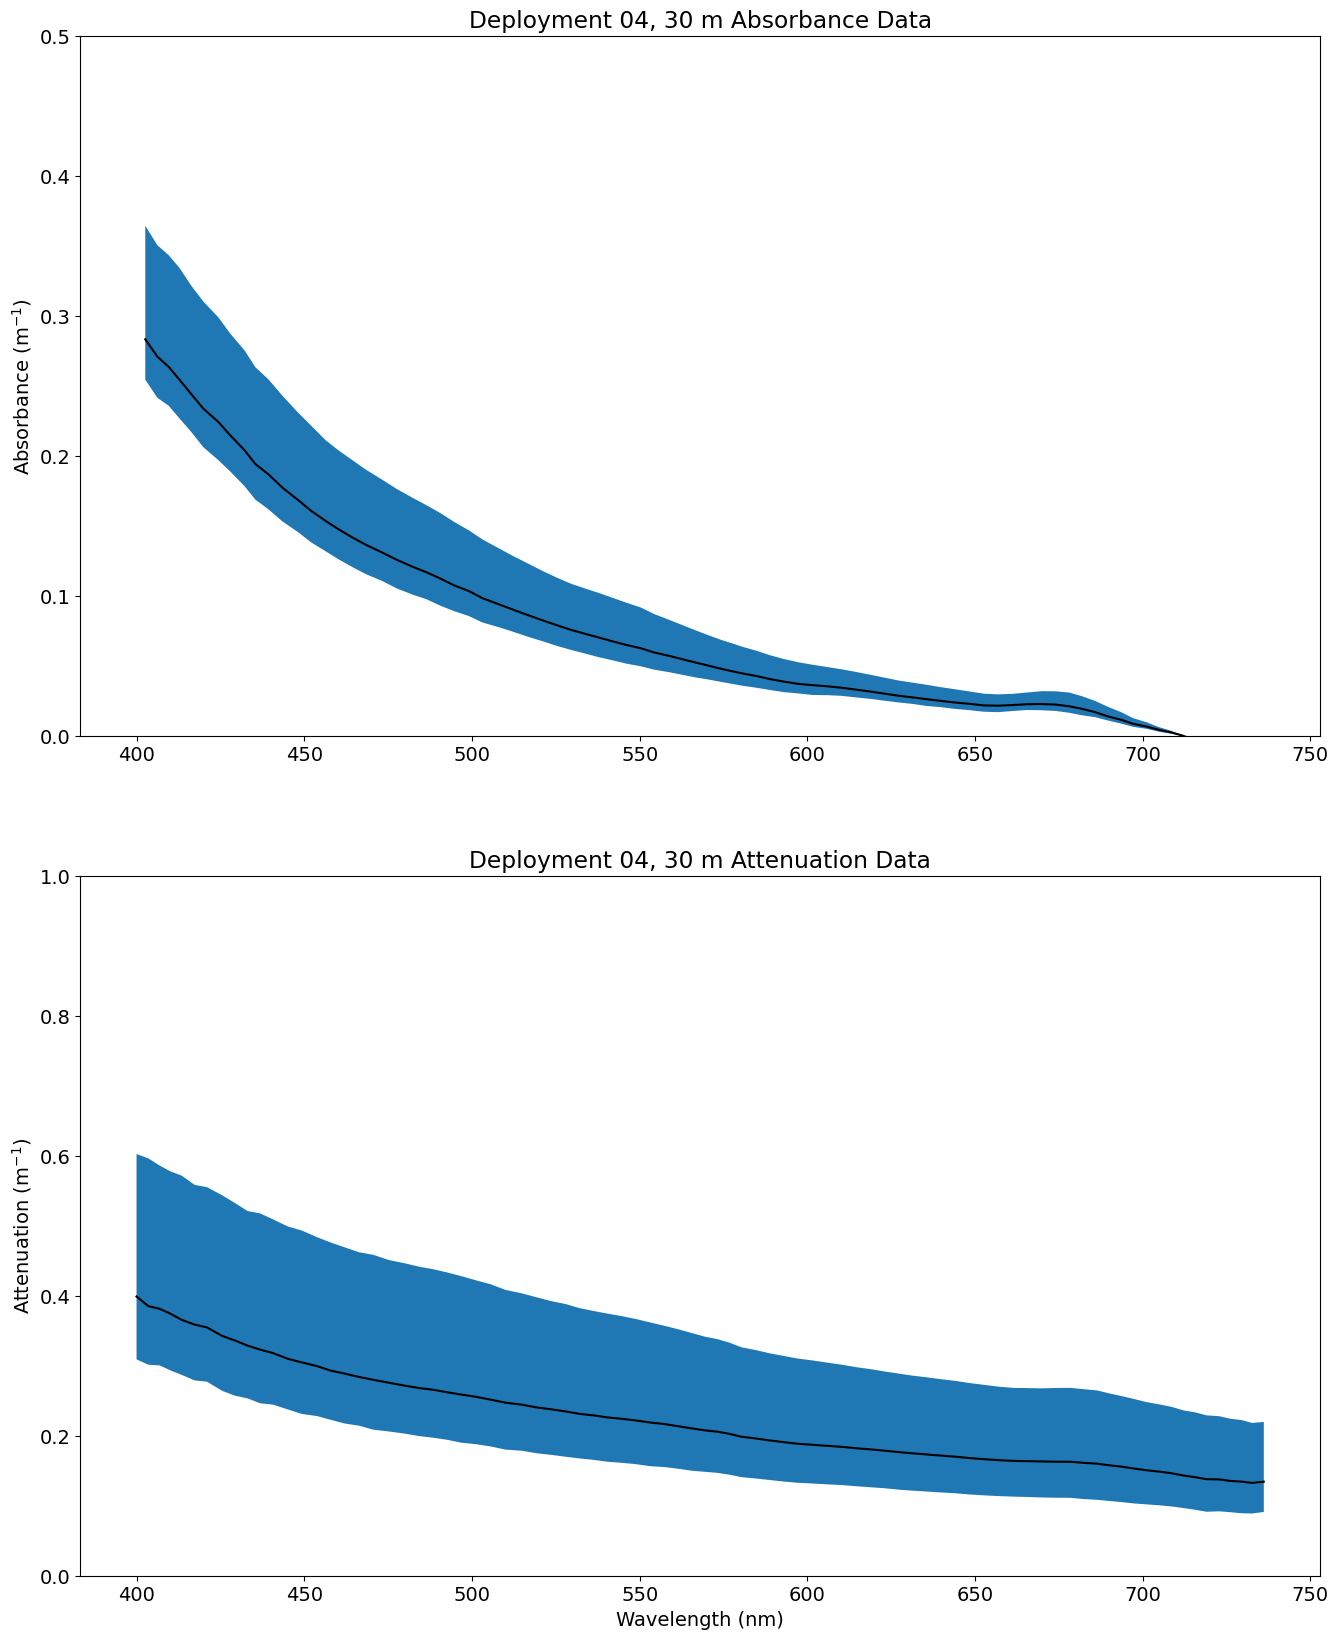

In [16]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(211)
plt.plot(slice30['wavelength_a'][0, :], slice30['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(slice30['wavelength_a'][0, :], slice30['apg_ts_s'].min(axis=0), 
                 slice30['apg_ts_s'].mean(axis=0) + (slice30['apg_ts_s'].std(axis=0) * 3))
plt.ylim([0, 0.5])
plt.title('Deployment 04, 30 m Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(slice30['wavelength_c'][0, :], slice30['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(slice30['wavelength_c'][0, :], slice30['cpg_ts'].min(axis=0), 
                 slice30['cpg_ts'].mean(axis=0) + (slice30['cpg_ts'].std(axis=0) * 3))
plt.ylim([0, 1])
plt.title('Deployment 04, 30 m Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.show()